In [36]:


%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report,
    roc_curve, auc, precision_recall_curve
)
import warnings
warnings.filterwarnings('ignore')

sns.set(style="whitegrid", font_scale=1.1)

In [37]:
df = pd.read_csv('dataset.csv')
print("Dataset loaded successfully!")
print(f"Shape: {df.shape}\n")
df.head()

Dataset loaded successfully!
Shape: (8763, 26)



Patient ID  Age     Sex  Cholesterol Blood Pressure  Heart Rate  Diabetes  \
0    BMW7812   67    Male          208         158/88          72         0   
1    CZE1114   21    Male          389         165/93          98         1   
2    BNI9906   21  Female          324         174/99          72         1   
3    JLN3497   84    Male          383        163/100          73         1   
4    GFO8847   66    Male          318          91/88          93         1   

   Family History  Smoking  Obesity  ...  Sedentary Hours Per Day  Income  \
0               0        1        0  ...                 6.615001  261404   
1               1        1        1  ...                 4.963459  285768   
2               0        0        0  ...                 9.463426  235282   
3               1        1        0  ...                 7.648981  125640   
4               1        1        1  ...                 1.514821  160555   

         BMI  Triglycerides  Physical Activity Days Per Week  \
0  31.251233            286                                0   
1  27.194973            235                                1   
2  28.176571            587                                4   
3  36.464704            378                                3   
4  21.809144            231                                1   

   Sleep Hours Per Day    Country      Continent           Hemisphere  \
0                    6  Argentina  South America  Southern Hemisphere   
1                    7     Canada  North America  Northern Hemisphere   
2                    4     France         Europe  Northern Hemisphere   
3                    4     Canada  North America  Northern Hemisphere   
4                    5   Thailand           Asia  Northern Hemisphere   

   Heart Attack Risk  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  

[5 rows x 26 columns]

In [38]:
df[['Systolic', 'Diastolic']] = df['Blood Pressure'].str.split('/', expand=True).astype(int)


In [39]:
df = df.drop(['Patient ID', 'Blood Pressure', 'Country', 'Continent', 'Hemisphere'], axis=1)


In [40]:
df['Sex'] = df['Sex'].map({'Male': 1, 'Female': 0})


In [41]:
X = df.drop('Heart Attack Risk', axis=1)
y = df['Heart Attack Risk']

# Define columns
numerical_cols = ['Age', 'Cholesterol', 'Heart Rate', 'Exercise Hours Per Week',
                  'Stress Level', 'Sedentary Hours Per Day', 'Income', 'BMI',
                  'Triglycerides', 'Physical Activity Days Per Week', 'Sleep Hours Per Day',
                  'Systolic', 'Diastolic', 'Sex']
categorical_cols = ['Diet']  # only categorical remaining

# Preprocessing pipeline with scaling + encoding
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
])

In [42]:
X_processed = preprocessor.fit_transform(X)

# Optional: Add polynomial features for non-linear patterns
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_processed)
feature_names = poly.get_feature_names_out(input_features=numerical_cols + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)))

print(f"Number of features after preprocessing & polynomial expansion: {X_poly.shape[1]}")

Number of features after preprocessing & polynomial expansion: 136


In [43]:
X_train, X_test, y_train, y_test = train_test_split(
    X_poly, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples\n")

Training set: 7010 samples
Test set: 1753 samples



In [44]:
logistic_model = LogisticRegression(
    solver='liblinear',  # efficient solver
    max_iter=2000,
    class_weight='balanced',  # handle class imbalance
    random_state=42
)

# Hyperparameter tuning
param_grid = {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}
grid_search = GridSearchCV(logistic_model, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print(f"Best hyperparameters: {grid_search.best_params_}")

Best hyperparameters: {'C': 10, 'penalty': 'l1'}


In [45]:
y_proba = best_model.predict_proba(X_test)[:,1]

# Choose threshold to improve recall/F1
threshold = 0.35
y_pred = (y_proba >= threshold).astype(int)

# ========================================
# Step 6: Performance Evaluation
# ========================================
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\n" + "="*50)
print("       LOGISTIC REGRESSION PERFORMANCE")
print("="*50)
print(f"Accuracy  : {acc:.4f}")
print(f"Precision : {prec:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"F1-Score  : {f1:.4f}")
print("="*50)



       LOGISTIC REGRESSION PERFORMANCE
Accuracy  : 0.3691
Precision : 0.3592
Recall    : 0.9713
F1-Score  : 0.5245


In [46]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Risk','High Risk']))



Classification Report:
              precision    recall  f1-score   support

     No Risk       0.67      0.03      0.06      1125
   High Risk       0.36      0.97      0.52       628

    accuracy                           0.37      1753
   macro avg       0.52      0.50      0.29      1753
weighted avg       0.56      0.37      0.23      1753



<Figure size 600x500 with 0 Axes>

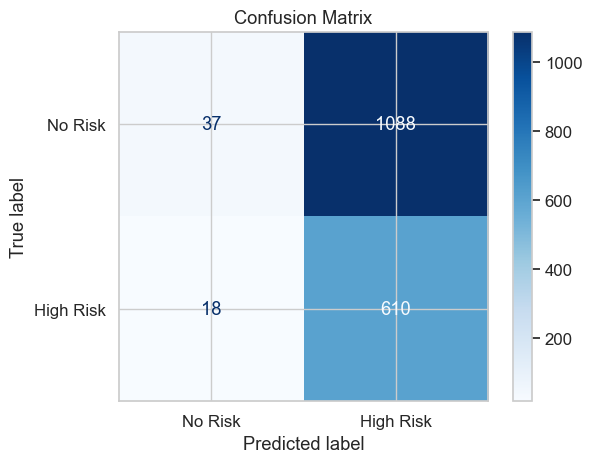

In [47]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
ConfusionMatrixDisplay(cm, display_labels=['No Risk','High Risk']).plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

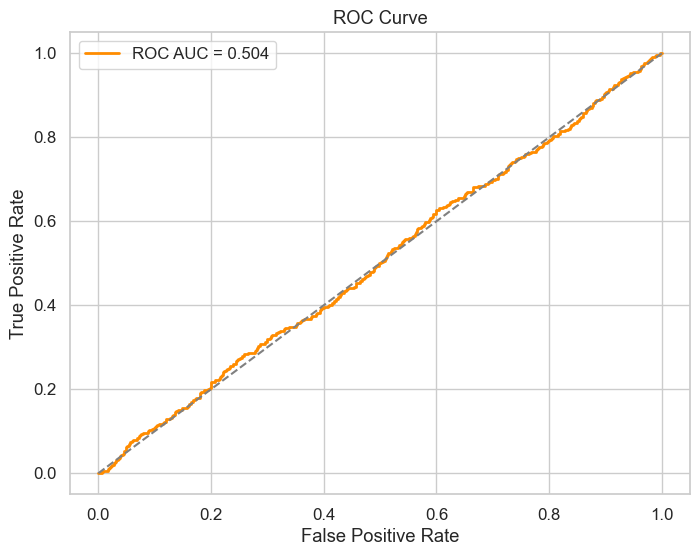

In [48]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC AUC = {roc_auc:.3f}')
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

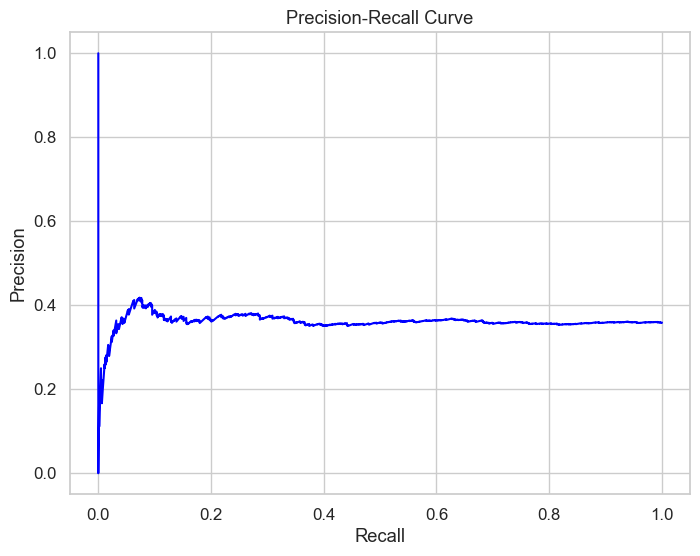

In [49]:
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(8,6))
plt.plot(recall_curve, precision_curve, color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In [50]:
coefficients = best_model.coef_[0]
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Odds Ratio': np.exp(coefficients)
}).sort_values(by='Coefficient', ascending=False)

print("\nTop 10 Features Increasing Risk:")
print(coef_df.head(10)[['Feature','Coefficient','Odds Ratio']])
print("\nTop 10 Features Decreasing Risk:")
print(coef_df.tail(10)[['Feature','Coefficient','Odds Ratio']][::-1])



Top 10 Features Increasing Risk:
                                               Feature  Coefficient  \
131                             Diastolic Diet_Healthy     0.146193   
133                                   Sex Diet_Healthy     0.065393   
67                         Exercise Hours Per Week Sex     0.063547   
63   Exercise Hours Per Week Physical Activity Days...     0.061166   
11                                            Systolic     0.053730   
83               Sedentary Hours Per Day Triglycerides     0.051897   
14                                        Diet_Healthy     0.049915   
6                                               Income     0.048622   
23                                   Age Triglycerides     0.045561   
36                                     Cholesterol BMI     0.045399   

     Odds Ratio  
131    1.157420  
133    1.067578  
67     1.065609  
63     1.063076  
11     1.055200  
83     1.053267  
14     1.051182  
6      1.049823  
23     1.046615  
36  

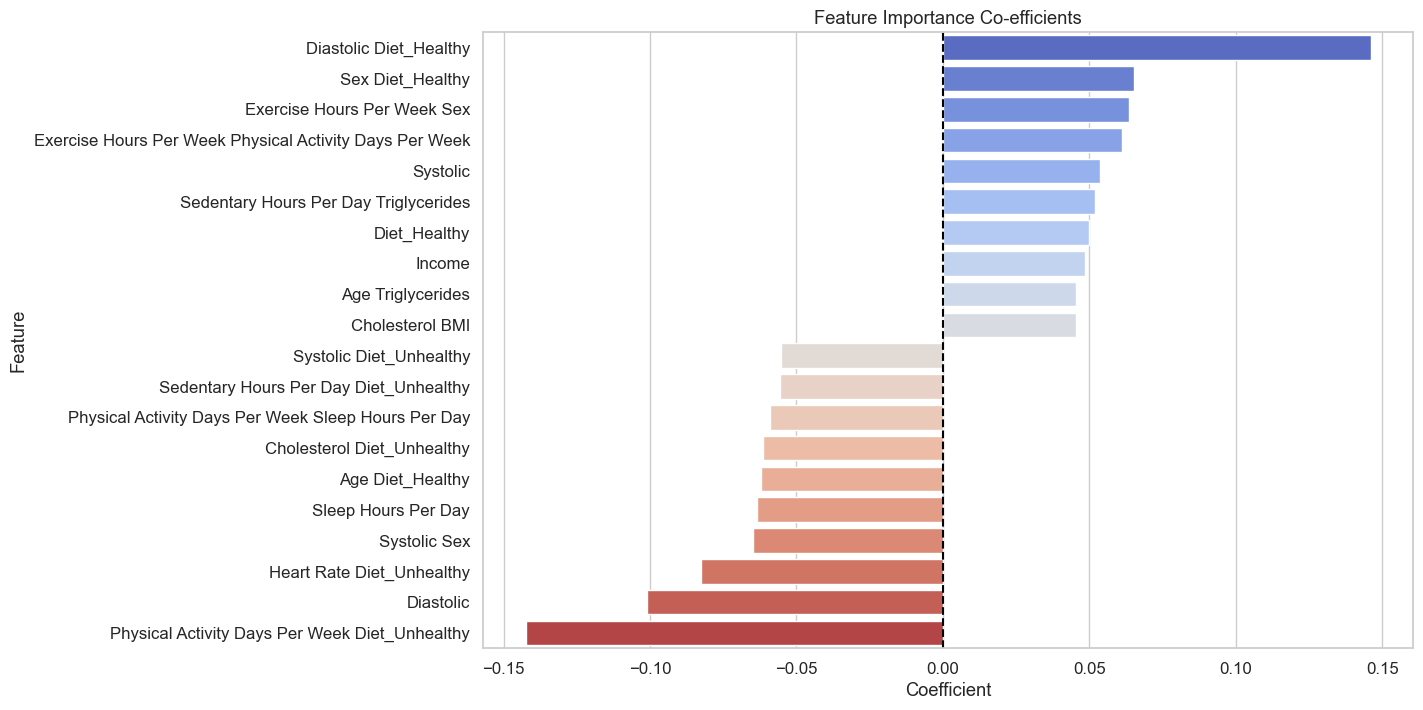

In [51]:
plt.figure(figsize=(12,8))
top_features = pd.concat([coef_df.head(10), coef_df.tail(10)])
sns.barplot(x='Coefficient', y='Feature', data=top_features, palette='coolwarm')
plt.axvline(0,color='black',linestyle='--')
plt.title('Feature Importance Co-efficients')
plt.show()

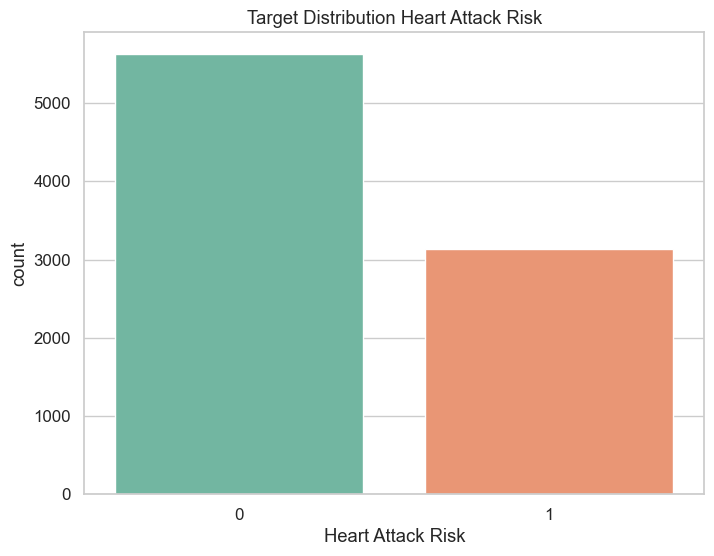

In [52]:
plt.figure(figsize=(8,6))
sns.countplot(x='Heart Attack Risk', data=df, palette='Set2')
plt.title('Target Distribution Heart Attack Risk')
plt.show()

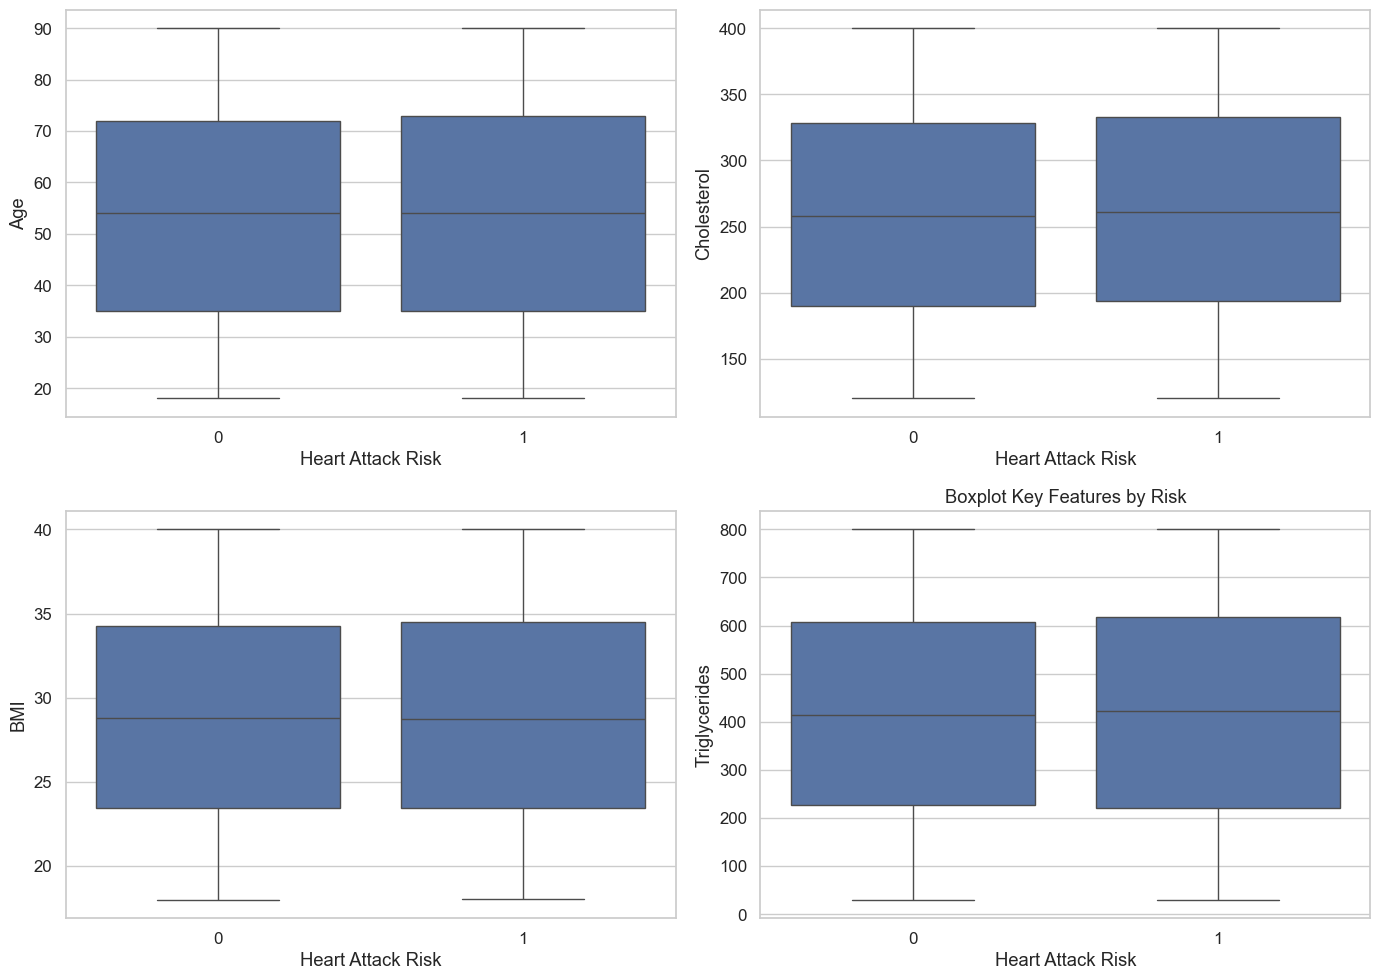

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(14,10))

sns.boxplot(x='Heart Attack Risk', y='Age', data=df, ax=axes[0,0])
sns.boxplot(x='Heart Attack Risk', y='Cholesterol', data=df, ax=axes[0,1])
sns.boxplot(x='Heart Attack Risk', y='BMI', data=df, ax=axes[1,0])
sns.boxplot(x='Heart Attack Risk', y='Triglycerides', data=df, ax=axes[1,1])

plt.tight_layout()
plt.show()


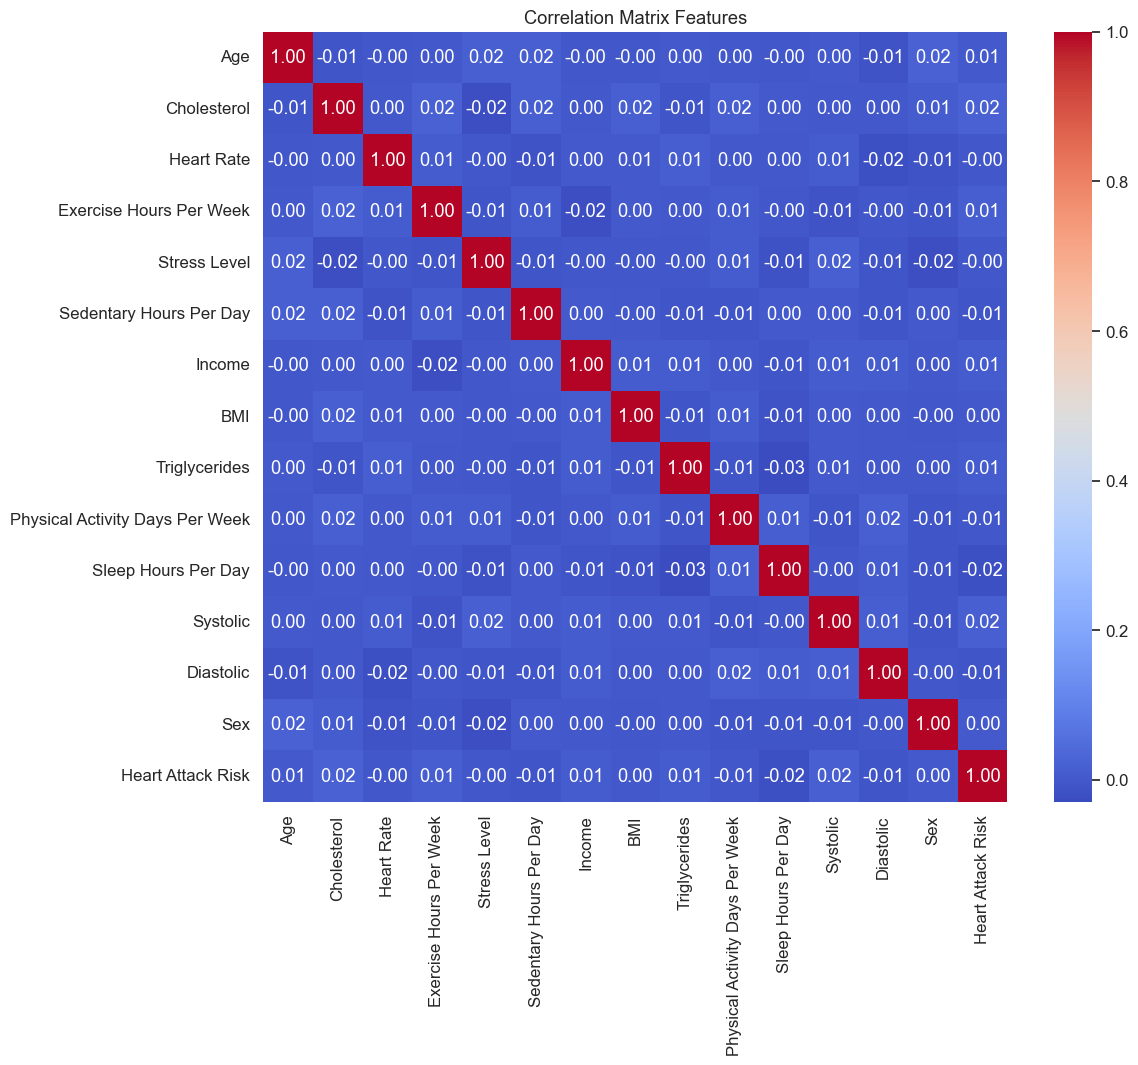

In [54]:
plt.figure(figsize=(12,10))
corr = df[numerical_cols + ['Heart Attack Risk']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Features')
plt.show()


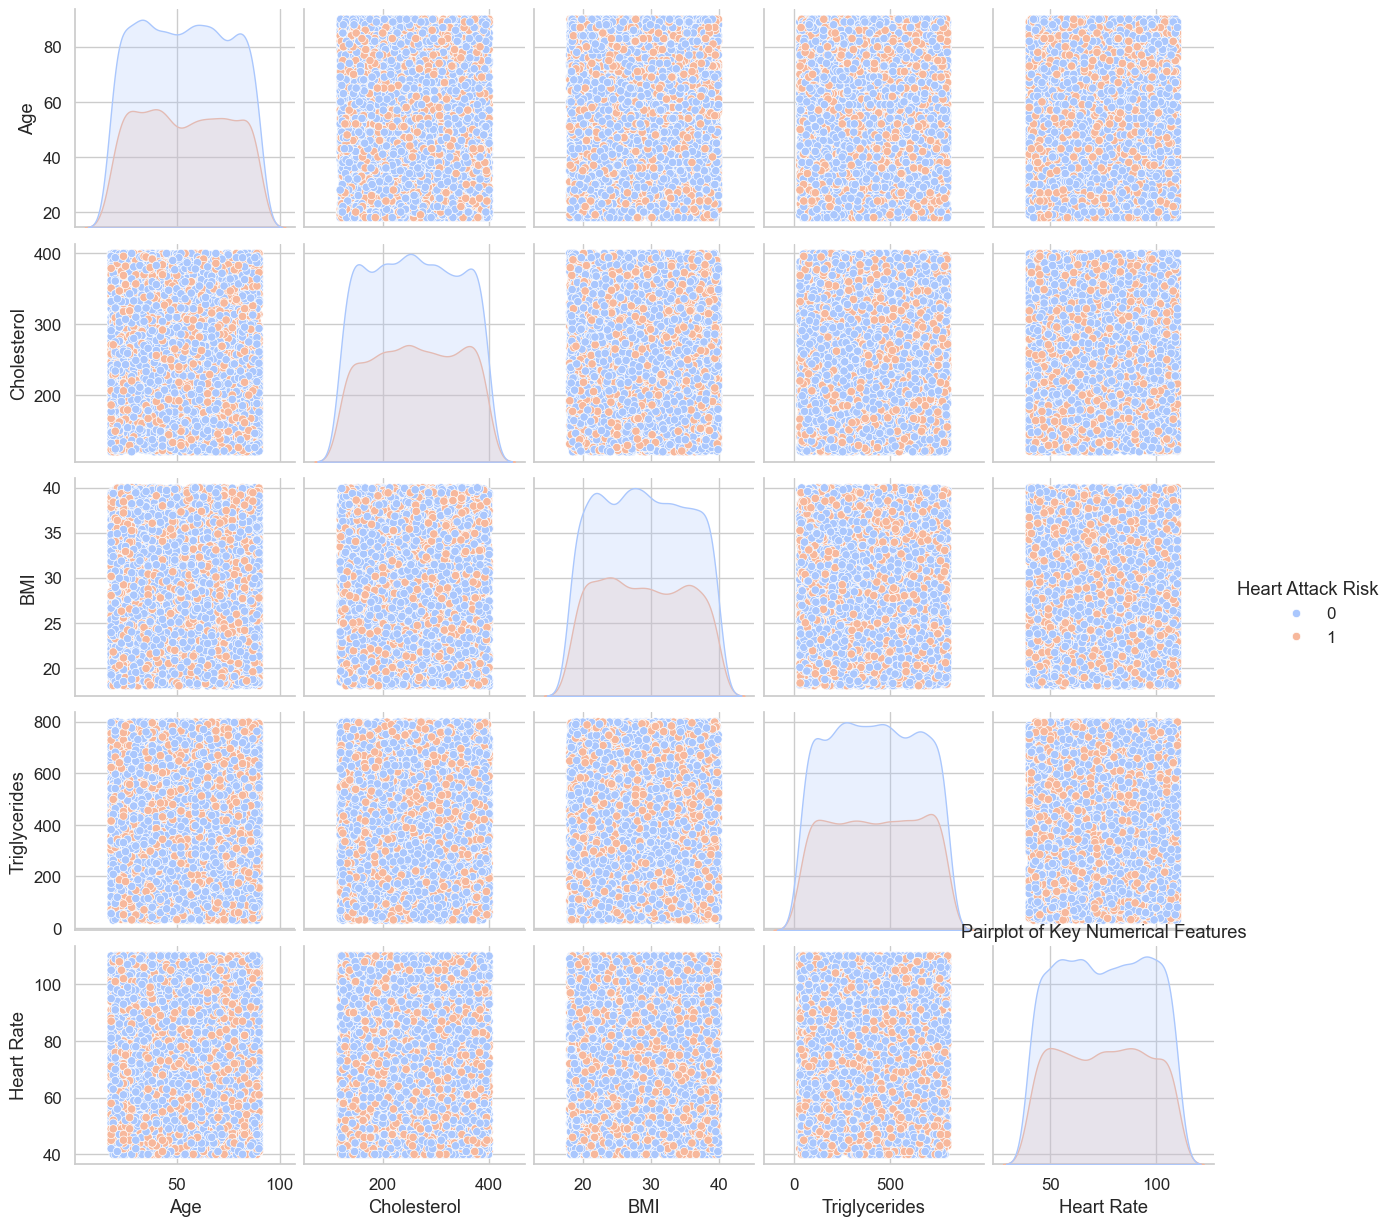

In [ ]:
key_num_features = ['Age', 'Cholesterol', 'BMI', 'Triglycerides', 'Heart Rate']
sns.pairplot(df[key_num_features + ['Heart Attack Risk']], hue='Heart Attack Risk', palette='coolwarm', diag_kind='kde')

plt.show()

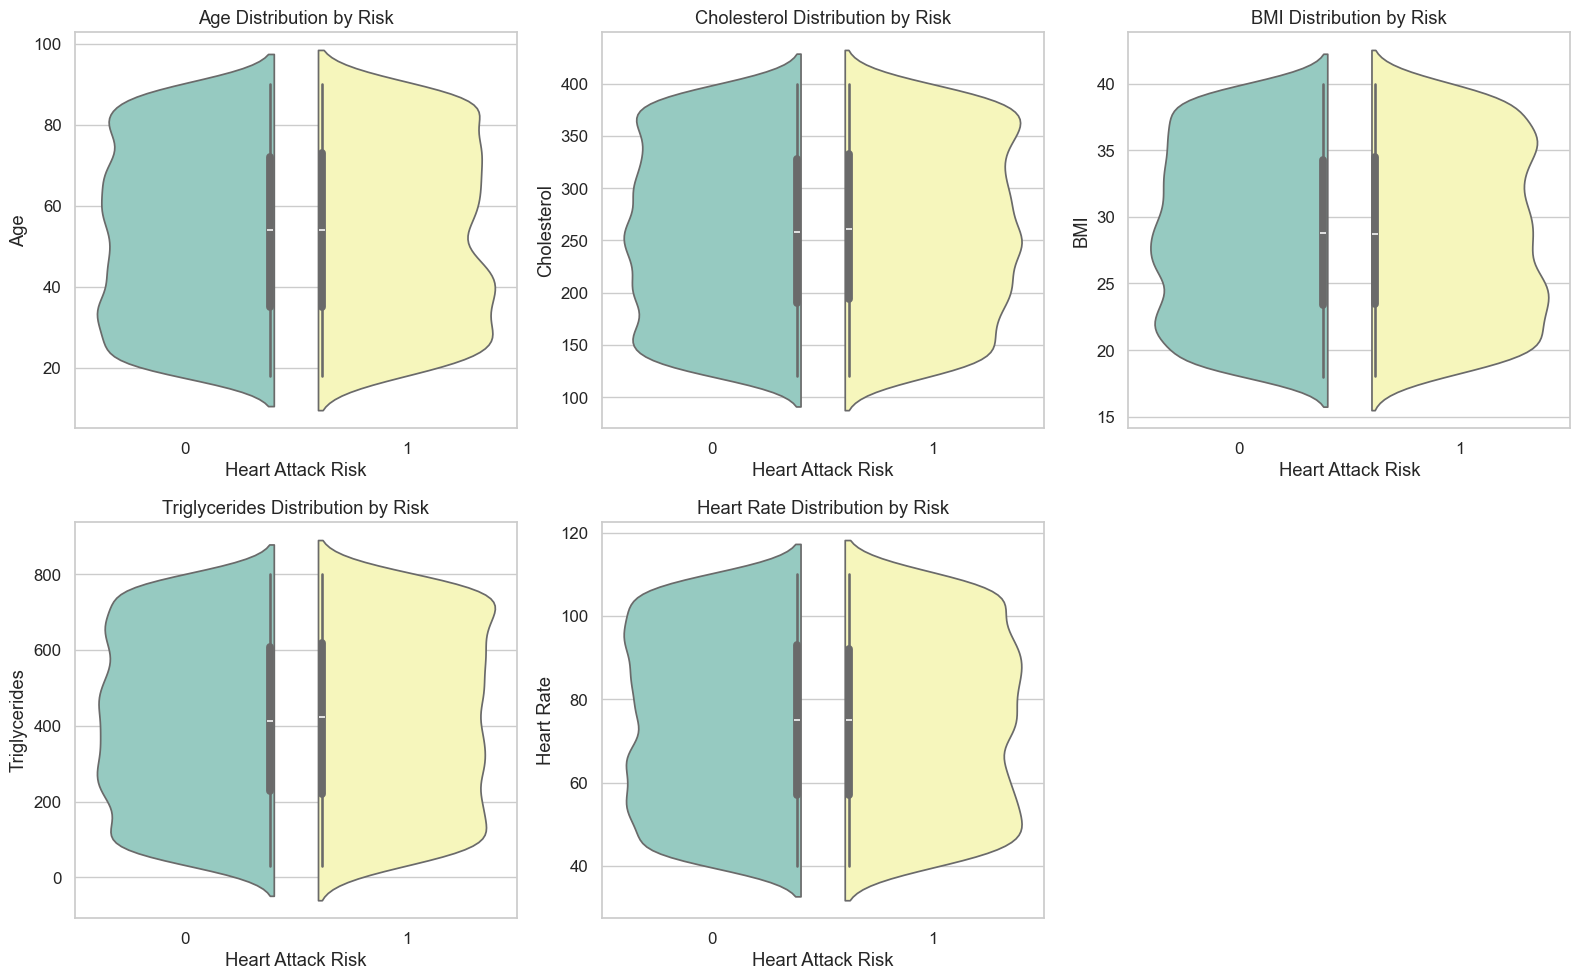

In [67]:
fig, axes = plt.subplots(2,3, figsize=(16,10))
axes = axes.flatten()

for i, col in enumerate(key_num_features):
    sns.violinplot(x='Heart Attack Risk', y=col, data=df, ax=axes[i], palette='Set3', split=True)
    axes[i].set_title(f'{col} Distribution by Risk')
fig.delaxes(axes[5])

plt.tight_layout()

plt.show()

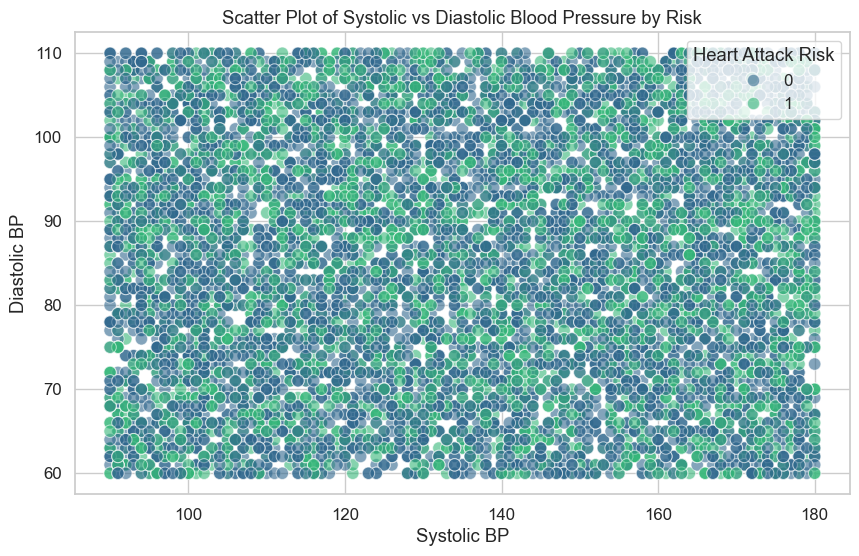

In [57]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='Systolic', y='Diastolic', hue='Heart Attack Risk', data=df, palette='viridis', s=80, alpha=0.6)
plt.title('Scatter Plot of Systolic vs Diastolic Blood Pressure by Risk')
plt.xlabel('Systolic BP')
plt.ylabel('Diastolic BP')
plt.show()

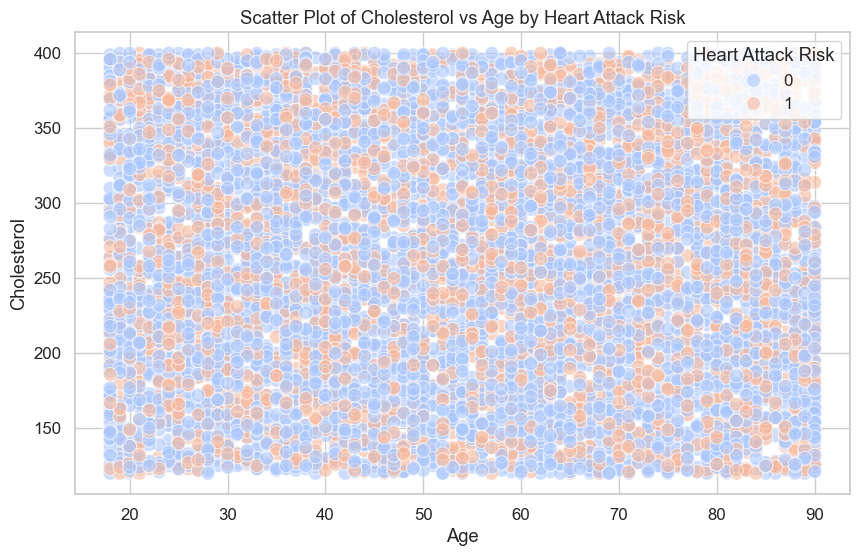

In [58]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='Age', y='Cholesterol', hue='Heart Attack Risk', data=df, palette='coolwarm', s=100, alpha=0.6)
plt.title('Scatter Plot of Cholesterol vs Age by Heart Attack Risk')
plt.show()


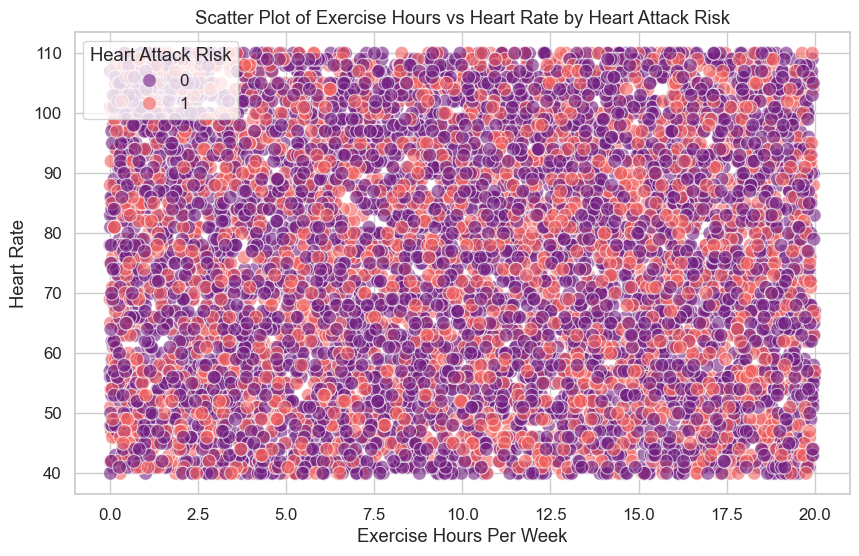

In [59]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='Exercise Hours Per Week', y='Heart Rate', hue='Heart Attack Risk', data=df, palette='magma', s=100, alpha=0.6)
plt.title('Scatter Plot of Exercise Hours vs Heart Rate by Heart Attack Risk')
plt.show()

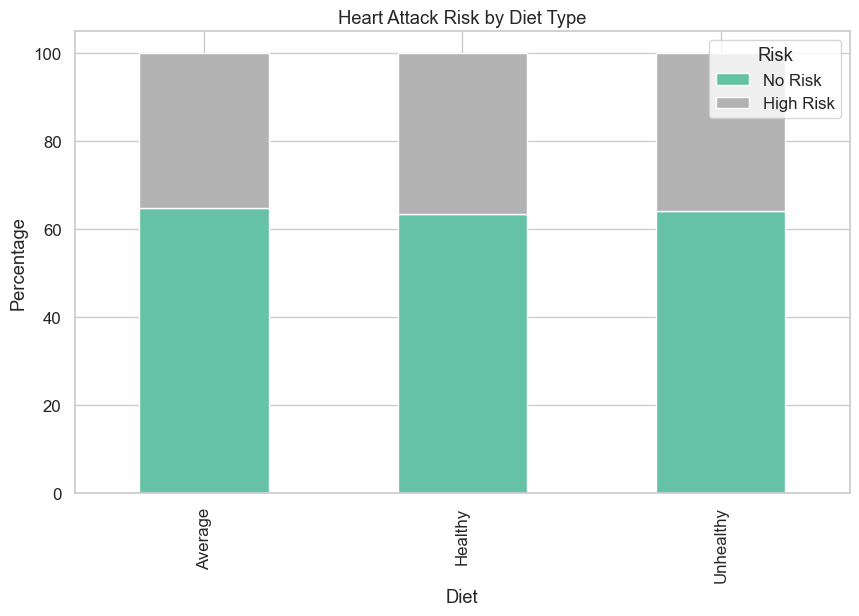

In [60]:
diet_risk = pd.crosstab(df['Diet'], df['Heart Attack Risk'], normalize='index') * 100
diet_risk.plot(kind='bar', stacked=True, figsize=(10,6), colormap='Set2')
plt.ylabel('Percentage')
plt.title('Heart Attack Risk by Diet Type')
plt.legend(['No Risk','High Risk'], title='Risk')
plt.show()

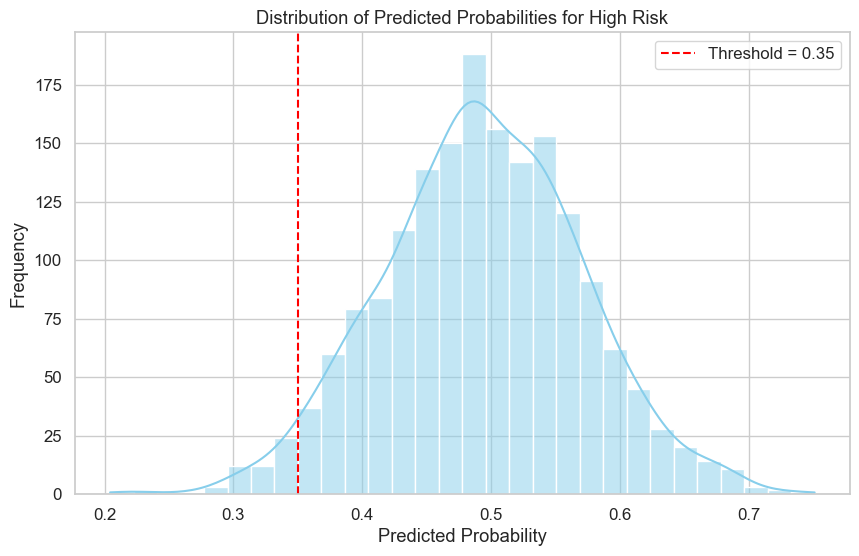

In [61]:

plt.figure(figsize=(10,6))
sns.histplot(y_proba, bins=30, kde=True, color='skyblue')
plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
plt.title('Distribution of Predicted Probabilities for High Risk')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.legend()
plt.show()
